In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import ParDMD, ParROM, DMD, ROM
import matplotlib.pyplot as plt
import time
import scipy.interpolate as si
import pandas as pd

In [2]:
dt = 3.0013e-2
## ======== Loading parameters =============
params = coor = pd.read_csv('../DATA/struc_doe_csv/params.csv', sep=';', 
                            engine='python', header=None, skiprows=2).stack().str.replace(',','.').unstack().to_numpy()[:, 1:3].astype(np.float)
p = params.shape[0]

for i in range(p):

    fln = "../DATA/struc_doe_csv/solid_disp_x_"+str(i+1)+".csv"
    with open(fln) as f:
        lines = (line for line in f if not line.startswith('#'))
        if i:
            u_x = np.concatenate((u_x, np.loadtxt(lines, delimiter=',',)), axis = 1)    ## -------------- solid x-displacement
        else:
            u_x = np.loadtxt(lines, delimiter=',',)
    fln = "../DATA/struc_doe_csv/solid_disp_y_"+str(i+1)+".csv"
    with open(fln) as f:
        lines = (line for line in f if not line.startswith('#'))
        if i:
            u_y = np.concatenate((u_y, np.loadtxt(lines, delimiter=',',)), axis = 1)    ## -------------- solid x-displacement
        else:
            u_y = np.loadtxt(lines, delimiter=',',)    ## -------------- solid x-displacement 

nx = u_x.shape[0]
ntt = int(u_x.shape[1]/p)

x = np.vstack((u_x, u_y))
X = x.swapaxes(0, 1).reshape((p, ntt, 2*nx),).swapaxes(1, 2)

train_t = np.arange(0, ntt)*dt

/var/folders/mp/h7b8hbp16j3dsm48zv_kfqzc0000gn/T/ipykernel_57991/2205085172.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine='python', header=None, skiprows=2).stack().str.replace(',','.').unstack().to_numpy()[:, 1:3].astype(np.float)


In [3]:
params

array([[ 2.        , -6.        ],
       [ 2.        , -2.        ],
       [15.        , -6.        ],
       [15.        , -2.        ],
       [ 2.00148695, -6.        ],
       [15.        , -3.92738981],
       [ 2.        , -3.90080247],
       [ 8.39045108, -2.        ],
       [15.        , -3.96700985],
       [ 8.37329579, -2.        ],
       [ 8.74715118, -6.        ],
       [ 7.928     , -4.272     ]])

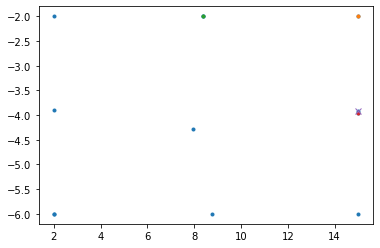

In [4]:
plt.plot(params[:, 0], params[:, 1], '.');
plt.plot(params[3, 0], params[3, 1], '.');
plt.plot(params[7, 0], params[7, 1], '.');
plt.plot(params[8, 0], params[8, 1], '.');

plt.plot(params[5, 0], params[5, 1], 'x');

In [5]:
choose = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
pard = ParDMD()
muROM = ParROM(pard)

muROM.decompose(X = X[choose, :, :], params = params[choose, :].T, dt = dt, normalize = True, rank = 0)

In [6]:
chc = 6
test_mu = params[chc, :].reshape((-1, 1))

pred_t = train_t.copy()
result_ = np.real(muROM.predict(pred_t, test_mu, stabilize=False, method=2, kernel='quintic', t1=dt))

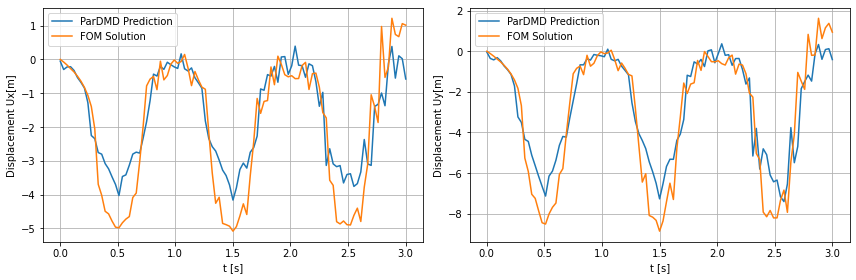

In [7]:
node = 23
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(pred_t, result_[nx-node, :], label = "ParDMD Prediction");
ax[0].plot(train_t, X[chc, nx-node, :], label = "FOM Solution");
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("Displacement Ux[m]");
#ax[0].set_title("Velocity at x/L =  " + str(L * (nx - node + 1)/nx));
#ax[0].axvline(train_t[-1], color = 'r', label = "Training regime");
ax[0].legend();

ax[1].plot(pred_t, result_[2*nx-node, :], label = "ParDMD Prediction");
ax[1].plot(train_t, X[chc, 2*nx-node, :], label = "FOM Solution");
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("Displacement Uy[m]");
#ax[1].set_title("Pressure at x/L =  " + str(L * (nx - node + 1)/nx));
#ax[1].axvline(train_t[-1], color = 'r', label = "Training regime");
ax[1].legend();

fig.tight_layout();

In [8]:
params

array([[ 2.        , -6.        ],
       [ 2.        , -2.        ],
       [15.        , -6.        ],
       [15.        , -2.        ],
       [ 2.00148695, -6.        ],
       [15.        , -3.92738981],
       [ 2.        , -3.90080247],
       [ 8.39045108, -2.        ],
       [15.        , -3.96700985],
       [ 8.37329579, -2.        ],
       [ 8.74715118, -6.        ],
       [ 7.928     , -4.272     ]])

## Manifold Interpolation Approach

In [9]:
from rom_am import ManDMD

In [10]:
choose = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]
params_ = params[choose, :].T
mndmd = ManDMD()
manROM = ParROM(mndmd)

manROM.decompose(X = X[choose, :, :], params = params_, dt = dt, normalize = True, rank = 0, kernel = 'quintic', iref=7, method=4, exp=False)

In [11]:
chc = 5
in_t = 1
init = X[chc, :, :]/manROM.snap_norms[:, np.newaxis]
init = init[:, in_t]

test_mu = params[chc, :].reshape((-1, 1))
#pred = np.real(manROM.predict(pred_t, test_mu, stabilize=False, method=4, t1 = train_t[in_t]))
#pred = np.real(manROM.predict(pred_t, test_mu, stabilize=True, method=2, init = init, t1 = train_t[in_t]))
#pred = np.real(manROM.predict(pred_t, test_mu, stabilize=True, method=14, init = init, t1 = train_t[in_t]))
pred = np.real(manROM.predict(pred_t, test_mu, stabilize=True, method=1, init = init, t1 = train_t[in_t], cutoff=1., rank = None))
#pred = np.real(manROM.predict(pred_t, test_mu, stabilize=False, method=0, t1 = train_t[0], init = 4))

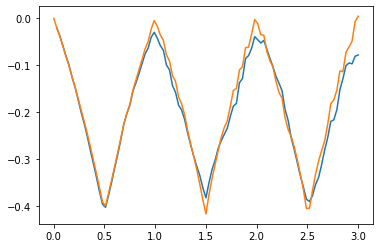

In [12]:
node = 20
plt.plot(pred_t[in_t::], pred[nx-node, in_t::], '-');
plt.plot(train_t, X[chc, nx-node, :], '-');